In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)

In [3]:
a, b, c = 0, 10, 100

### 1. Trapezoid approx

In [4]:
from scipy.special import beta

def p(x, a=0, b=10, c=100):
    x = np.asarray(x)
    
    _alpha = 1 + 4 * (b - a) / (c -a)
    _beta =  1 + 4 * (c - b) / (c - a)
    
    pdf = np.zeros_like(x)
    support = (x >= a) & (x <= c)
    
    pdf[support] = ((x[support] - a)**(_alpha - 1) * (c - x[support])**(_beta - 1)) / (beta(_alpha, _beta) * (c - a)**(_alpha + _beta - 1))    
    return pdf 

In [5]:
E_X = (a + 4*b + c) / 6
var_X = ((E_X - a) * (c - E_X)) / 7

E_X, var_X

(23.333333333333332, 255.55555555555557)

In [6]:
def integrand(x):
    return x * p(x)


def trapezoid(f, a, b, n=1000):
    x = np.linspace(a, b, n + 1)
    y = f(x)
    h = (b - a) / n
    T = h * (y[0]/2 + y[1:-1].sum() + y[-1]/2)
    return T

In [7]:
trapezoid(integrand, a, b)

np.float64(1.2914794278720907)

In [8]:
E_hat = 0
for i in range(1,2000):
    E_hat = trapezoid(integrand, a, c, n=i)
    error = np.abs(E_X - E_hat)
    if error < 5e-5:    # 4 decimal places
        print(f"Converged at n={i} with error={error:.6f}")
        break

Converged at n=271 with error=0.000050


In [9]:
E_hat

np.float64(23.333283756106006)

In [10]:
# h = (b-a)/n;
# T = (f(a)+f(b))/2;
#    for i = 1:n-1
#       T = T + f(a+i*h);
#    end
# T = T*h;

### 2. CLT estimation

E_n = N(E[X], (c - a)^2 sigma**2 / n) \
E[x] = 1.96 * (c - a) sigma / sqrt(n)

n >= ((1.96 * (c - a) sigma) / error)**2

In [11]:
n0 = 1000
x = np.random.uniform(a, c, n0)

y = x * p(x)
sigma_hat = np.std(y, ddof=1)

target_error = 5e-3 # 2 decimals
z = 1.96  # for 95% confidence interval
n_req = (z * (c - a) * sigma_hat / target_error)**2   

sigma_hat, n_req

(np.float64(0.19294611441271603), np.float64(57206345.96082096))

### 3. Verify the estimates

In [12]:
n = int(np.ceil(n_req))

means = []
n_estimates = 100
for _ in range(n_estimates):
    x = np.random.uniform(a, c, n)
    fx = c * integrand(x)

    mean = np.mean(fx)
    std_dev = np.std(fx) / np.sqrt(n)    
    means.append(mean)
    
    error = np.abs(mean - E_X)
    print(f"Estimate: {mean:.6f}, Std Dev: {std_dev:.6f}, Error: {error:.6f}")    
    

Estimate: 23.333452, Std Dev: 0.002523, Error: 0.000119
Estimate: 23.333438, Std Dev: 0.002523, Error: 0.000105
Estimate: 23.334186, Std Dev: 0.002523, Error: 0.000853
Estimate: 23.333634, Std Dev: 0.002523, Error: 0.000301
Estimate: 23.333545, Std Dev: 0.002523, Error: 0.000212
Estimate: 23.330470, Std Dev: 0.002523, Error: 0.002863
Estimate: 23.330322, Std Dev: 0.002523, Error: 0.003012
Estimate: 23.335377, Std Dev: 0.002523, Error: 0.002044
Estimate: 23.333769, Std Dev: 0.002523, Error: 0.000436
Estimate: 23.337346, Std Dev: 0.002523, Error: 0.004013
Estimate: 23.328527, Std Dev: 0.002523, Error: 0.004806
Estimate: 23.335334, Std Dev: 0.002523, Error: 0.002001
Estimate: 23.334472, Std Dev: 0.002523, Error: 0.001139
Estimate: 23.331623, Std Dev: 0.002523, Error: 0.001711
Estimate: 23.333718, Std Dev: 0.002523, Error: 0.000384
Estimate: 23.335368, Std Dev: 0.002523, Error: 0.002035
Estimate: 23.335237, Std Dev: 0.002523, Error: 0.001904
Estimate: 23.333881, Std Dev: 0.002523, Error: 0

### All estimates below 0.005, therefore the estimate is correct

### Comparison, discussion
Trapezoid up to 4 decimals with < 1k iterations while MC integration requires milions just to reach second decimal accuracy, so in this case the trapezoid is much more efficient

Text(0.5, 1.0, 'Distribution of Sample Means')

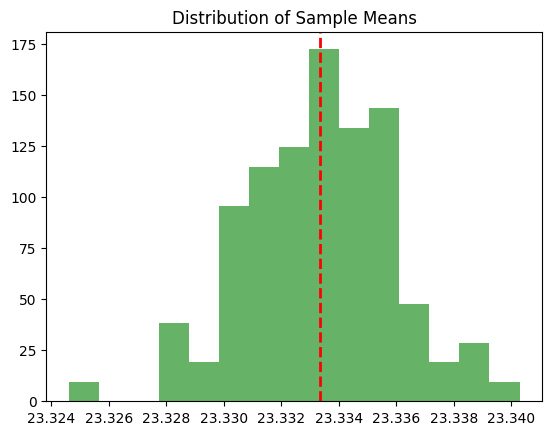

In [13]:
plt.hist(means, bins=15, density=True, alpha=0.6, color='g', label='Sample Means')
plt.axvline(E_X, color='r', linestyle='dashed', linewidth=2, label='True Mean')
plt.title('Distribution of Sample Means')

could add more estimates but is slow

## 2. Importance sampling

In [14]:
def f(x):
    return x ** (-0.75) * np.exp(-x)

### 2.1 Plot on [0, 1]

C:\Users\sebas\AppData\Local\Temp\ipykernel_15136\34507342.py:2: RuntimeWarning: divide by zero encountered in power
  return x ** (-0.75) * np.exp(-x)


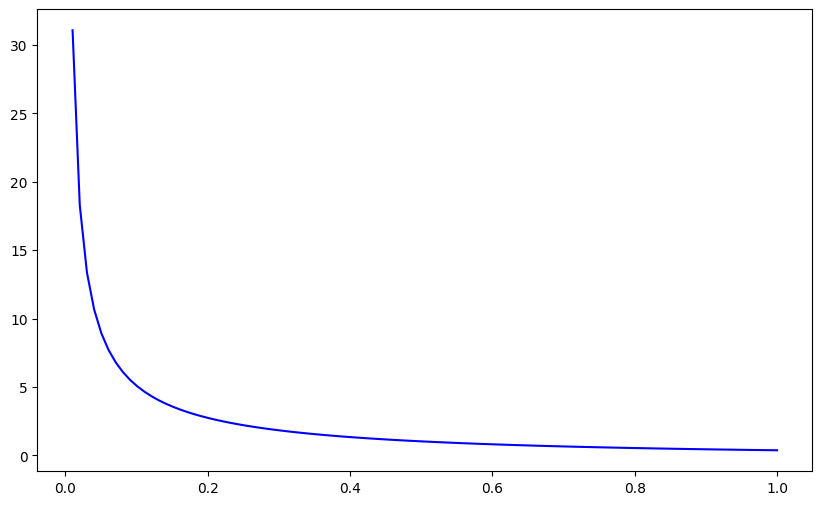

In [15]:
x = np.linspace(0, 1, 100)
plt.figure(figsize=(10, 6))
plt.plot(x, f(x), label='f(x) = x^(-0.75) + exp(-x)', color='blue')


### 2.2 Uniform sample MC

In [16]:
a = 0
b = 1

In [17]:
np.random.seed(42)

n = 10**7

estimates = []

for _ in range(10):
    x = np.random.uniform(0, 1, int(n))
    fx = f(x)
    
    # est =  (b - a) * np.mean(fx)
    est =  np.mean(fx)
    estimates.append(est)
    
estimates = np.array(estimates)
mean_I = np.mean(estimates)
std_I = np.std(estimates)

print(f"Mean Estimate: {mean_I:.6f}, Std Dev: {std_I:.6f}")


Mean Estimate: 3.363956, Std Dev: 0.088954


### 2.3 Estimate I by q

In [18]:
# I x^{-3/4} dx = [x^{1/4} / (1/4)] = 4, so c = 1/4
n = int(10e7)
c = 1/4


def q(x, c=1/4):
    return c * x**(-0.75)

def cdf_q(x):
    return x ** 0.25

def inv_cdf_q(x):
    return x ** 4

estimates = []
for _ in range(10):
    u = np.random.uniform(0, 1, size=n)
    x = inv_cdf_q(u)
    fx = f(x)
    qx = q(x)
    W = fx / qx
    
    estimates.append(np.mean(W) * (b - a))

In [19]:
np.mean(estimates), np.std(estimates)

(np.float64(3.379365859509803), np.float64(0.00010303512761783043))

### 2.4. Compare (report)

### 3. Metropolis-Hastings Algorithm

In [20]:
x_data = np.array([0.3, 0.5, 0.75, 0.4])

In [21]:
def posterior_dist(alpha, eta, x):
    return alpha * eta * x ** (alpha - 1) * np.exp(-(x)**alpha * eta)

In [22]:
from scipy.stats import multivariate_normal

np.random.seed(42)

def log_prior(alpha, eta):
    if alpha <= 0 or eta <= 0:
        return -np.inf
    return -alpha - 2 * eta + np.log(eta)

def log_likelihood(alpha, eta, x):
    if alpha <= 0 or eta <= 0:
        return -np.inf
    return np.sum(np.log(alpha) + np.log(eta) + (alpha - 1)*np.log(x) - eta * x**alpha)

def log_posterior(alpha, eta, x):
    return log_prior(alpha, eta) + log_likelihood(alpha, eta, x)

def propose_mvn(current, cov):
    return np.random.multivariate_normal(current, cov)

def exp_proposal_pdf(x, mean):
    alpha, eta = x
    a0, e0 = mean
    if alpha <= 0 or eta <= 0:
        return 0
    return (1/a0)*np.exp(-alpha/a0) * (1/e0)*np.exp(-eta/e0)

def propose_exp(current):
    alpha_ = np.random.exponential(scale=current[0])
    eta_ = np.random.exponential(scale=current[1])
    return np.array([alpha_, eta_])


def metropolis_hastings(start, num_samples, proposal_fn, proposal_pdf=None, cov=None):
    samples = []
    current = np.array(start)
    logp_current = log_posterior(current[0], current[1], x_data)

    for _ in range(num_samples):
        if proposal_fn == "mvn":
            proposed = propose_mvn(current, cov)
            logp_proposed = log_posterior(proposed[0], proposed[1], x_data)
            # Symmetric proposal: q cancels
            accept_ratio = np.exp(logp_proposed - logp_current)
        else:  # exp
            proposed = propose_exp(current)
            logp_proposed = log_posterior(proposed[0], proposed[1], x_data)
            q_current = exp_proposal_pdf(current, proposed) # transition prob. from curr to proposed
            q_proposed = exp_proposal_pdf(proposed, current)
            accept_ratio = np.exp(logp_proposed - logp_current) * (q_current / q_proposed)

        print(accept_ratio)

        if np.random.rand() < min(1, accept_ratio):
            current = proposed
            logp_current = logp_proposed

        samples.append(current.copy())

    return np.array(samples)


In [23]:
chains_mvn = [metropolis_hastings(start=[1.0, 1.0], num_samples=1000, proposal_fn="mvn", cov=np.diag([0.1, 0.1]))
              for _ in range(5)]

chains_mvn_1 = [metropolis_hastings(start=[1.0, 1.0], num_samples=1000, proposal_fn="mvn", cov=np.diag([.5, .5])) for _ in range(5)]


chains_mvn_2 = [metropolis_hastings(start=[1.0, 1.0], num_samples=1000, proposal_fn="mvn", cov=np.array([[0.1, 0.01], [0.01, 0.1]])) for _ in range(5)]

chains_exp = [metropolis_hastings(start=[0.1, 1.0], num_samples=1000, proposal_fn="exp")
              for _ in range(5)]

1.0728173576533164
0.6880861161113264
2.007075859733174
0.8482229134696817
0.21908380967523056
0.3722462965198283
0.01793688926192648
1.87196884462719
0.9691368330479715
0.9275706978531421
0.28209273277418084
0.32542616179833084
4.022815326310716
1.4472926414908267
0.8095586271224511
1.280010925191601
1.094325352167535
0.8245090775841576
0.5529976407855739
1.0087215516390353
0.5920423814805931
0.08801303970494893
0.11826473403094052
2.8824211560639044
2.144347905789697
1.76405652523915
0.05534913371475052
0.002368722745172043
0.4595388858173159
0.03968350734067525
0.13454651948492038
1.052822119870126
0.1878818250582018
5.415076807873818
0.5996854106524178
3.6858399292178774
1.1525940312506373
0.9474117041767631
0.6909046134101127
0.11915965815226401
0.05939663361804029
1.4162614677024925
0.7158918972736069
1.2841893604448253
1.0525667493165003
0.29646352193959835
0.3222490224439705
0.4767075152567003
1.4441306205008844
1.2640856804512832
0.3952053291220125
1.2742404447622846
1.0016666

In [24]:
mvn_a = chains_mvn_1[0][:, 0]
mvn_e = chains_mvn_1[0][:, 1]

exp_a = chains_exp[0][:, 0]
exp_e = chains_exp[0][:, 1]

np.mean(mvn_a), np.mean(mvn_e), np.std(mvn_a), np.std(mvn_e)

np.mean(exp_a), np.mean(exp_e), np.std(exp_a), np.std(exp_e)

(np.float64(1.8220655838316644),
 np.float64(1.9481873660470717),
 np.float64(0.6803558576878275),
 np.float64(0.8181528674080906))

In [25]:
import arviz as az

In [26]:
def to_inference_data(chains, var_names=["alpha", "eta"]):
    # Chains: list of (n_samples, 2) arrays
    stacked = np.stack(chains, axis=0)  
    return az.convert_to_inference_data(
        {var_names[0]: stacked[:, :, 0], var_names[1]: stacked[:, :, 1]}
    )

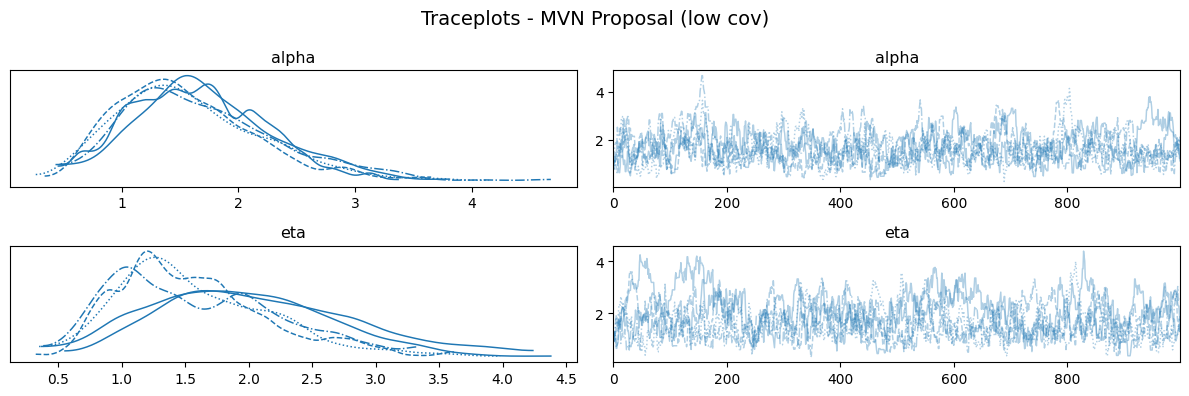

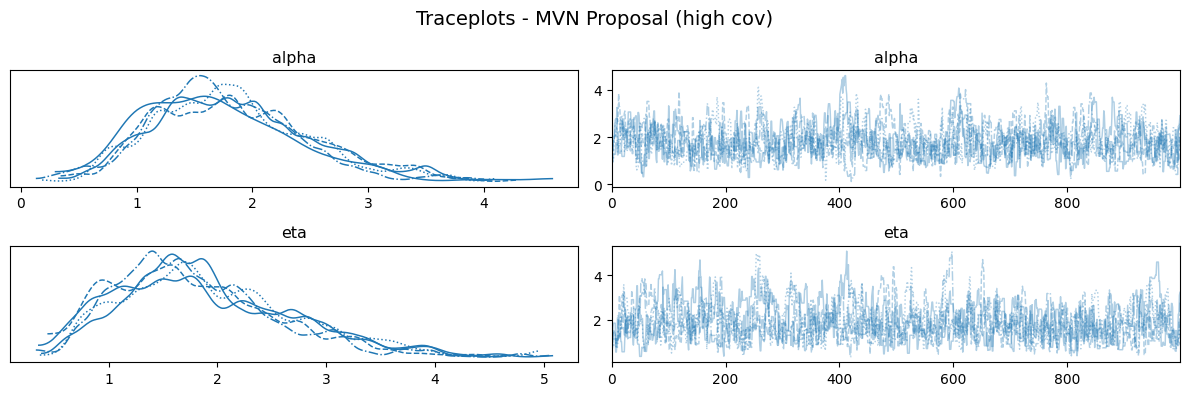

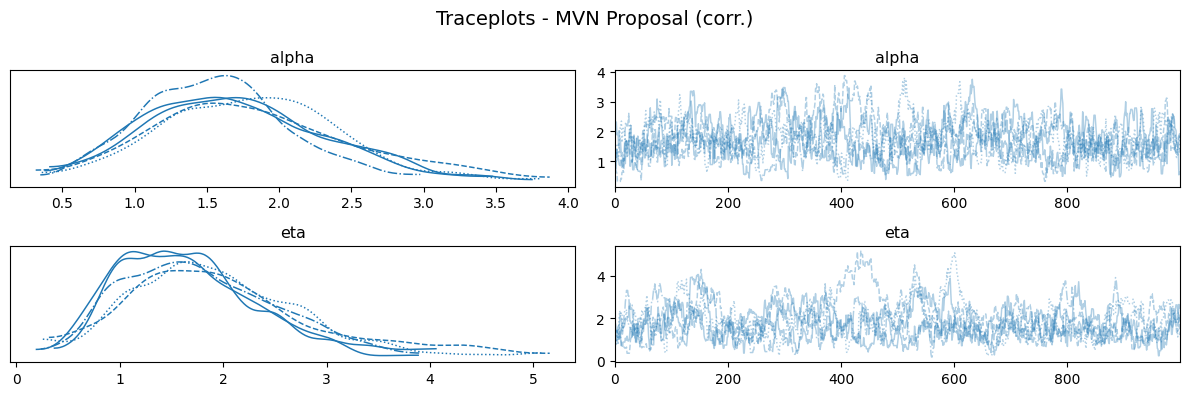

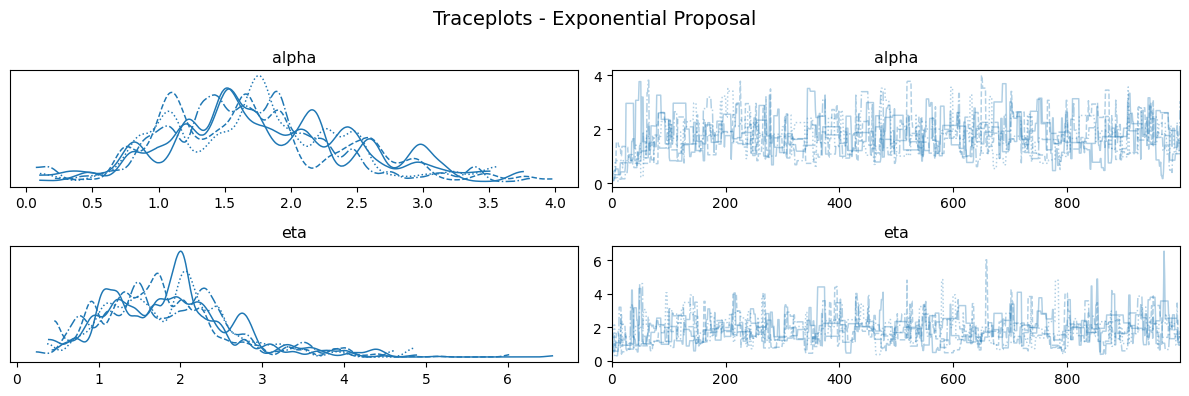

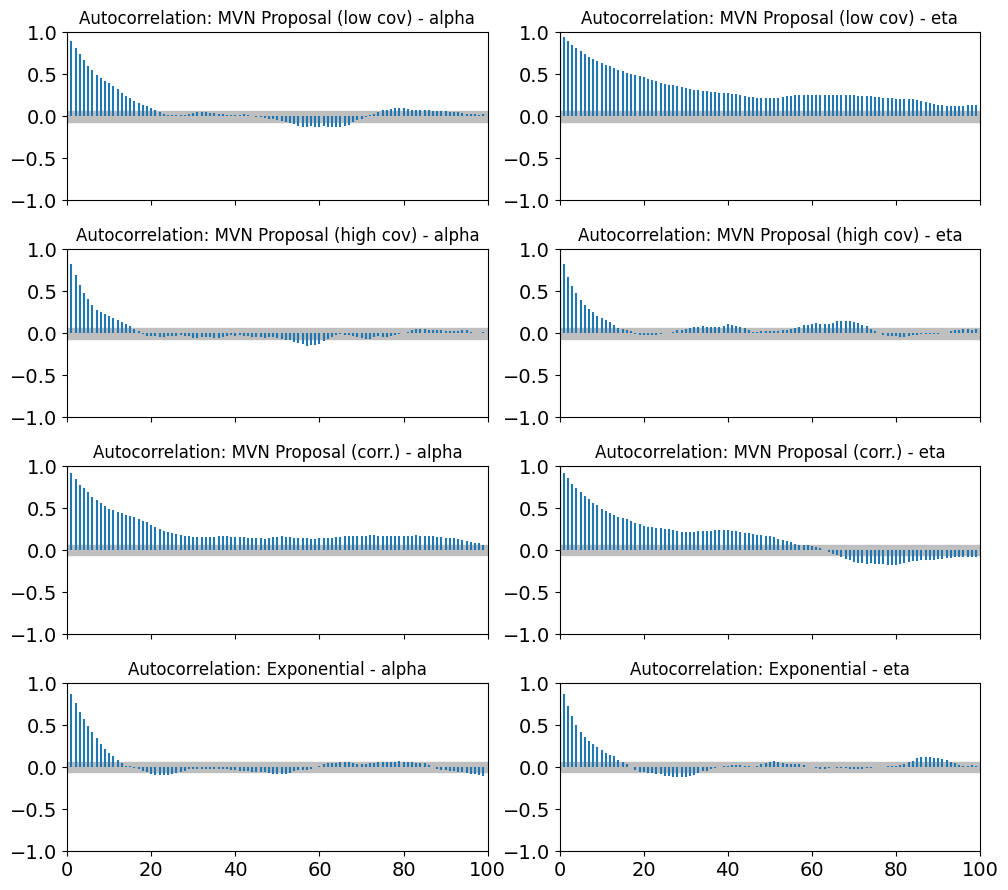

ESS (MVN proposal):
 <xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    alpha    float64 8B 189.8
    eta      float64 8B 57.35
ESS (MVN proposal):
 <xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    alpha    float64 8B 411.1
    eta      float64 8B 410.3
ESS (MVN proposal):
 <xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    alpha    float64 8B 148.8
    eta      float64 8B 147.6
ESS (Exp proposal):
 <xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    alpha    float64 8B 297.5
    eta      float64 8B 405.3


In [27]:
idata_mvn = to_inference_data(chains_mvn)
idata_exp = to_inference_data(chains_exp)
idata_mvn1 = to_inference_data(chains_mvn_1)
idata_mvn2 = to_inference_data(chains_mvn_2)

# Traceplots
az.plot_trace(idata_mvn)
plt.suptitle("Traceplots - MVN Proposal (low cov)", fontsize=14)
plt.tight_layout()
plt.show()

az.plot_trace(idata_mvn1)
plt.suptitle("Traceplots - MVN Proposal (high cov)", fontsize=14)
plt.tight_layout()
plt.show()

az.plot_trace(idata_mvn2)
plt.suptitle("Traceplots - MVN Proposal (corr.)", fontsize=14)
plt.tight_layout()
plt.show()

az.plot_trace(idata_exp)
plt.suptitle("Traceplots - Exponential Proposal", fontsize=14)
plt.tight_layout()
plt.show()

# Autocorrelation
# Plot autocorrelation for α

idata_list = [idata_mvn, idata_mvn1, idata_mvn2, idata_exp]
labels = ["MVN Proposal (low cov)", "MVN Proposal (high cov)", "MVN Proposal (corr.)", "Exponential"]
variables = ["alpha", "eta"]

fig, axes = plt.subplots(4, 2, figsize=(10, 9), sharex=True)

for i, (idata, label) in enumerate(zip(idata_list, labels)):
    for j, var in enumerate(variables):
        az.plot_autocorr(idata, var_names=[var], ax=axes[i, j])
        axes[i, j].set_title(f"Autocorrelation: {label} - {var}")

plt.tight_layout()
plt.show()




# ESS
ess_mvn = az.ess(idata_mvn)
ess_mvn_1 = az.ess(idata_mvn1)
ess_mvn_2 = az.ess(idata_mvn2)
ess_exp = az.ess(idata_exp)
print("ESS (MVN proposal):\n", ess_mvn)
print("ESS (MVN proposal):\n", ess_mvn_1)
print("ESS (MVN proposal):\n", ess_mvn_2)
print("ESS (Exp proposal):\n", ess_exp)


In [28]:
def unnormalized_posterior(alpha, eta, x):
    if alpha <= 0 or eta <= 0:
        return 0
    prior = np.exp(-alpha - 2*eta) * eta
    likelihood = np.prod(alpha * eta * x**(alpha - 1) * np.exp(-eta * x**alpha))
    return prior * likelihood

# Importance sampling
def estimate_prob(num_samples=10000, scale_alpha=1.0, scale_eta=1.0):
    samples = np.random.exponential(scale=[scale_alpha, scale_eta], size=(num_samples, 2))
    weights = []

    for alpha, eta in samples:
        p = unnormalized_posterior(alpha, eta, x_data)
        q = exp_proposal_pdf([alpha, eta], [scale_alpha, scale_eta])
        if q == 0:
            continue
        w = p / q
        if alpha >= 1.3 and eta >= 1.3:
            weights.append(w)

    total_weights = []
    for alpha, eta in samples:
        p = unnormalized_posterior(alpha, eta, x_data)
        q = exp_proposal_pdf([alpha, eta], [scale_alpha, scale_eta])
        if q != 0:
            total_weights.append(p / q)

    prob_est = sum(weights) / sum(total_weights)
    return prob_est


In [29]:
p_hat = estimate_prob()
p_hat

np.float64(0.568658338750475)

In [30]:
def estimate_prob_mcmc(samples, alpha_thresh=1.3, eta_thresh=1.3):
    count = 0
    for alpha, eta in samples:
        if alpha >= alpha_thresh and eta >= eta_thresh:
            count += 1
    return count / len(samples)


In [31]:
# Flatten all chains into one array
all_samples_exp = np.vstack(chains_exp)

# Estimate posterior probability that alpha >= 1.3 and eta >= 1.3
prob_est = estimate_prob_mcmc(all_samples_exp)
print(f"Estimated probability: {prob_est:.5f}")


Estimated probability: 0.58680
